In [15]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("default")


In [16]:
symbol = "^GSPC"
data = yf.download(symbol, start="2015-01-01", auto_adjust=True)

data['Returns'] = data['Close'].pct_change()
data = data.dropna()


[*********************100%***********************]  1 of 1 completed


Adjusted prices are used to ensure returns reflect total market movement.

### DEFINE THE MEAN REVERSION SIGNAL

In [17]:
window = 20

rolling_mean = data['Close'].rolling(window).mean()
rolling_std = data['Close'].rolling(window).std()

data['Z_Score'] = (data['Close'] - rolling_mean) / rolling_std
data = data.dropna()


Z-scores measure deviation from the rolling mean in standard deviation units.

### Trading rules

- Long when Z < -1

- Exit when Z > 0

- Flat otherwise

In [18]:
data['Signal'] = 0
data.loc[data['Z_Score'] < -1, 'Signal'] = 1
data.loc[data['Z_Score'] > 0, 'Signal'] = 0

data['Position'] = data['Signal'].shift(1)

num_trades = data['Position'].diff().abs().sum()
num_trades



np.float64(254.0)

### BACKTEST LOGIC

In [19]:
transaction_cost = 0.0
data['Strategy_Returns'] = (
     data['Position'] * data['Returns'] 
     - transaction_cost * data['Position'].diff().abs()
)


cum_market = (1 + data['Returns']).cumprod()
cum_strategy = (1 + data['Strategy_Returns']).cumprod()


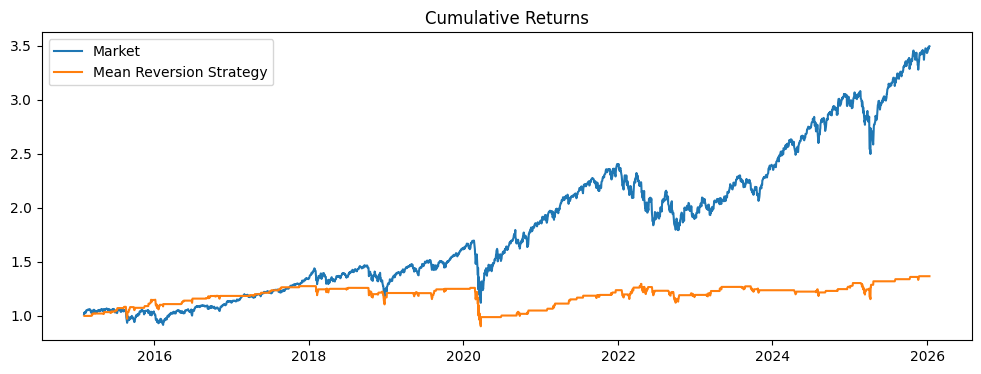

In [20]:
plt.figure(figsize=(12,4))
plt.plot(cum_market, label='Market')
plt.plot(cum_strategy, label='Mean Reversion Strategy')
plt.legend()
plt.title("Cumulative Returns")
plt.show()


### PERFORMANCE METRICS

In [21]:
def performance_metrics(returns):
    ann_return = returns.mean() * 252
    ann_vol = returns.std() * np.sqrt(252)
    risk_free_rate = 0.0
    sharpe = (ann_return - risk_free_rate) / ann_vol

    cum = (1 + returns).cumprod()
    drawdown = cum / cum.cummax() - 1
    max_dd = drawdown.min()
    
    return pd.Series({
        "Annualized Return": ann_return,
        "Annualized Volatility": ann_vol,
        "Sharpe Ratio": sharpe,
        "Max Drawdown": max_dd
    })

market_metrics = performance_metrics(data['Returns'])
strategy_metrics = performance_metrics(data['Strategy_Returns'])

pd.DataFrame({
    "Market": market_metrics,
    "Strategy": strategy_metrics
})


,Market,Strategy
Annualized Return,0.130596,0.036105
Annualized Volatility,0.178943,0.121833
Sharpe Ratio,0.729819,0.296351
Max Drawdown,-0.339250,-0.291017
